<a href="https://colab.research.google.com/github/whippyrock12-a11y/novamarket_corr/blob/main/8_3_Reporte_de_an%C3%A1lisis_de_correlaci%C3%B3n_NovaMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reporte de análisis de correlación - NovaMarket

## 1. Contexto y objetivo



El objetivo de este reporte es identificar relaciones entre métricas clave
de actividad y compras que podrían estar asociadas con el ingreso  mensual
en NovaMarket.

El análisis es exploratorio y correlacional; no busca establecer causalidad,
sino generar hipótesis para análisis posteriores.

## 2. Preparación y supuestos

- Dataset: nova_market_activity.csv
- Variables analizadas: métricas de actividad, compras e ingresos
- Limpieza: exclusión de usuarios sin visitas
- Supuesto clave: análisis correlacional (no causal)

In [ ]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("nova_market_activity.csv")

# Excluir usuarios sin actividad
df = df[df["visitas_ultimos_30d"] > 0]

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   visitas_ultimos_30d          1500 non-null   int64  
 1   compras                      1500 non-null   int64  
 2   gasto_publicitario_dirigido  1500 non-null   float64
 3   puntuacion_satisfaccion      1500 non-null   float64
 4   edad_cliente                 1500 non-null   float64
 5   estado_suscripcion           1500 non-null   object 
 6   region                       1500 non-null   object 
 7   tipo_dispositivo             1500 non-null   object 
 8   ingresos_mensuales           1500 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 105.6+ KB


,visitas_ultimos_30d,compras,gasto_publicitario_dirigido,puntuacion_satisfaccion,edad_cliente,estado_suscripcion,region,tipo_dispositivo,ingresos_mensuales
0,12,1,26.75,4.2,37.0,Yes,North,mobile,34.59
1,6,0,0.00,2.8,35.0,No,North,mobile,0.00
2,11,1,31.11,3.1,43.0,Yes,North,mobile,25.35
3,14,2,29.74,2.7,29.0,No,North,mobile,38.14
4,7,1,46.61,2.8,34.0,No,East,desktop,24.25


## 3. Visualización de relaciones iniciales

Observamos cómo se relacionan las variables numéricas usando
- Heatmap
- Scatterplot general
- Scatterplot para pares clave




### **Heatmap** para relaciones globales:

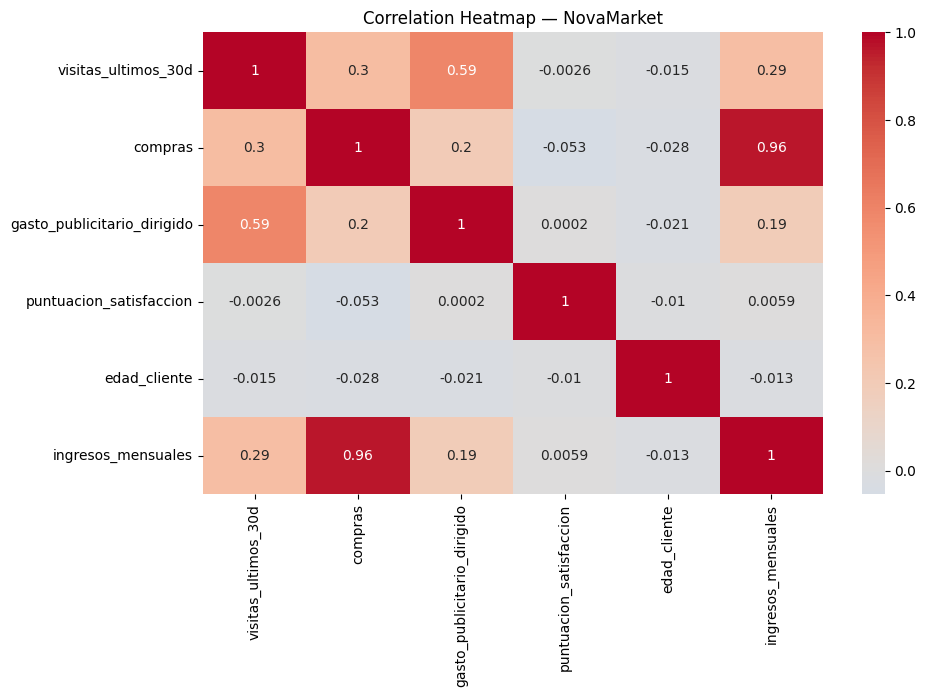

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap — NovaMarket")
plt.show()

### **Scatterplot** general:

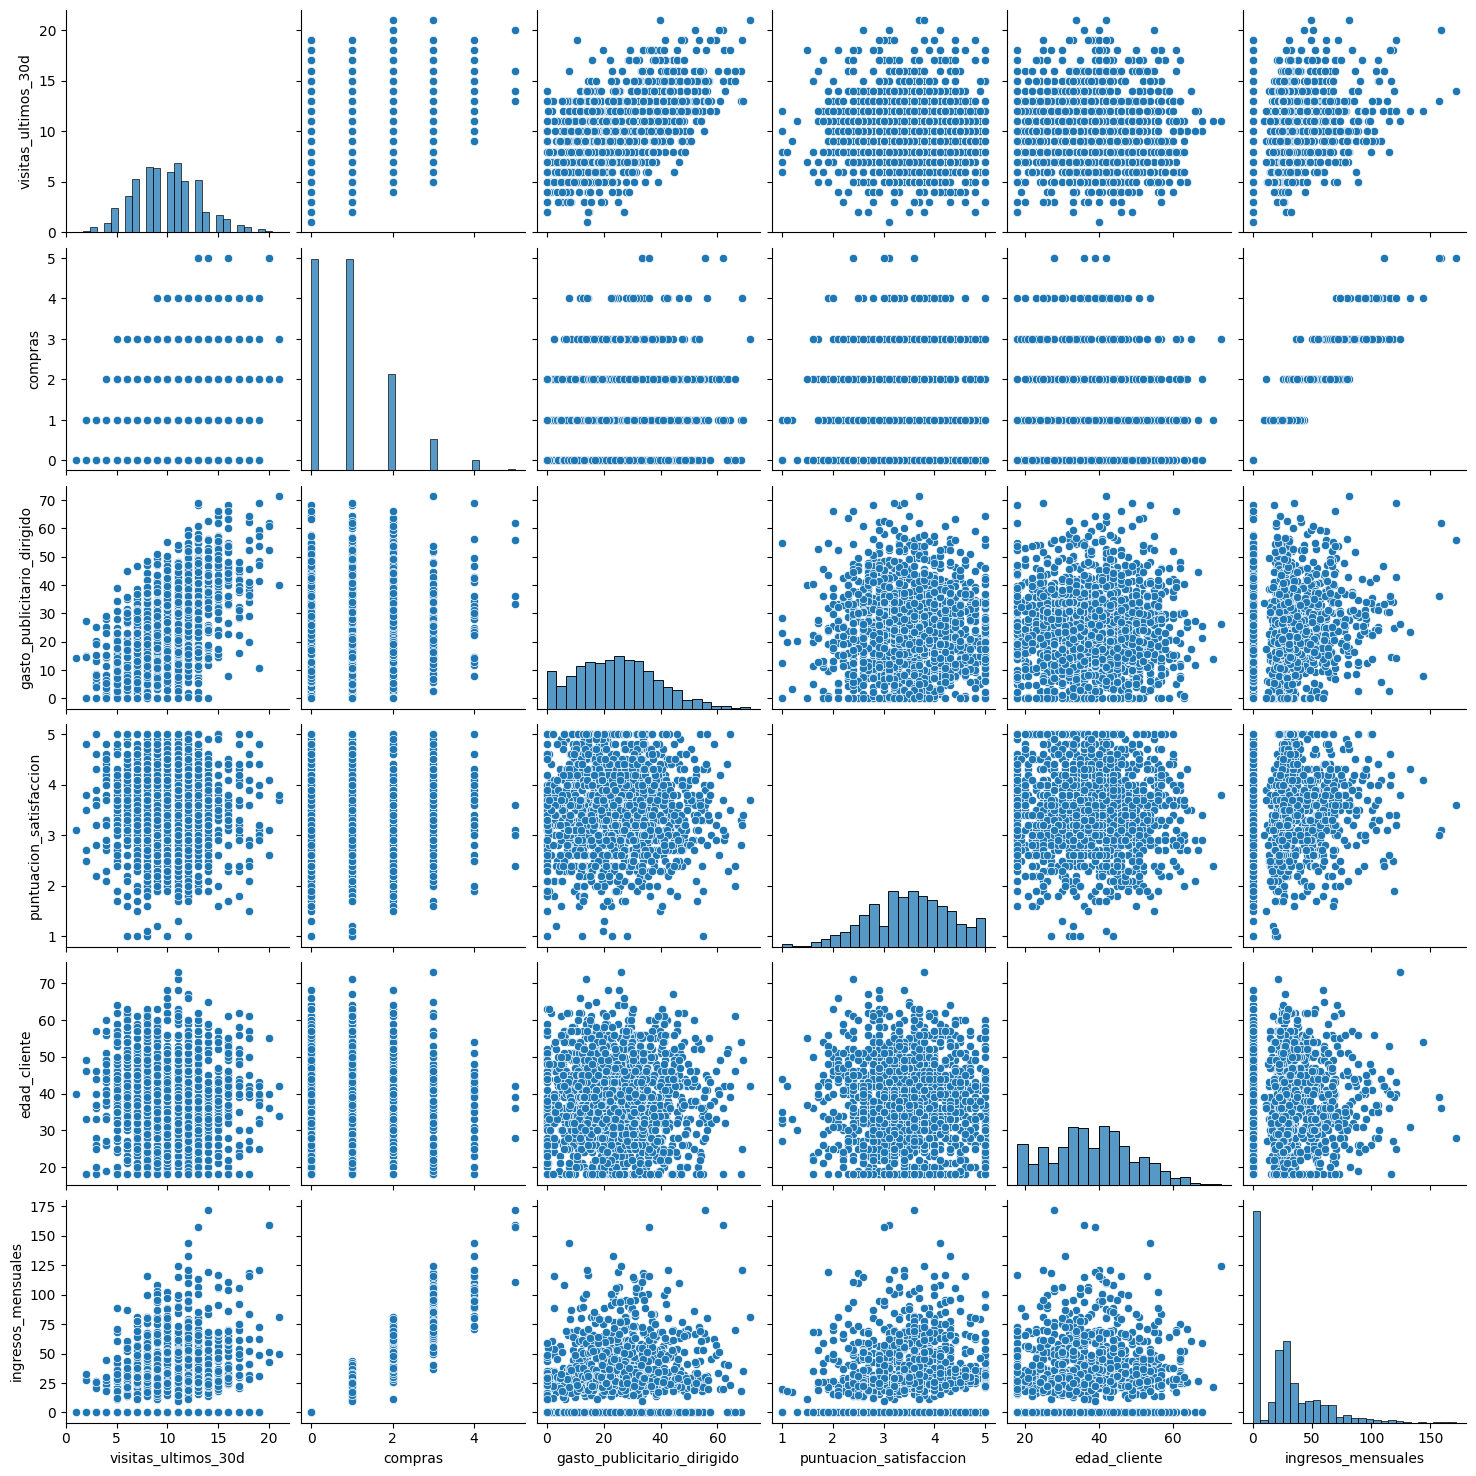

In [ ]:
sns.pairplot(df)
plt.show()

### **Scatterplot** para pares clave:

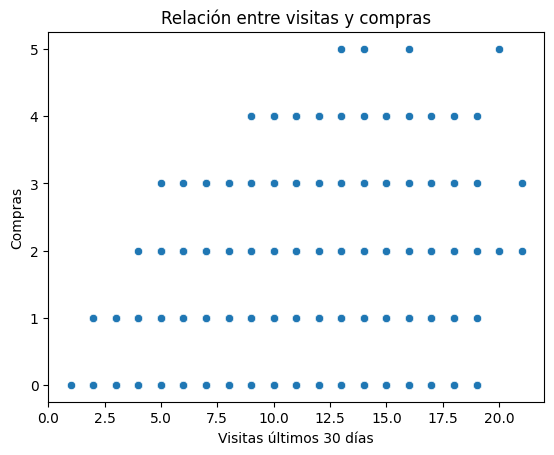

In [ ]:
sns.scatterplot(
    data=df,
    x="visitas_ultimos_30d",
    y="compras"
)

plt.title("Relación entre visitas y compras")
plt.xlabel("Visitas últimos 30 días")
plt.ylabel("Compras")
plt.show()

## 4. Coeficientes y evidencia numérica

En esta sección se reportan coeficientes que respaldan los patrones
observados visualmente, utilizando el método adecuado según el tipo
de variables.

### Pearson & Spearman (Visitas y Compras)
La correlación Pearson evalúa relación lineal.  
La correlación Spearman evalúa consistencia (monotonía).

La similitud entre ambos valores sugiere una relación
moderadamente lineal entre visitas y compras.

In [ ]:
# Correlación entre visitas y compras
corr_pearson  = df['visitas_ultimos_30d'].corr(df['compras'], method='pearson')
corr_spearman = df['visitas_ultimos_30d'].corr(df['compras'], method='spearman')

print(f"Correlacion entre: visitas_ultimos_30d y compras")
print(f"Pearson: {corr_pearson:.3f}")
print(f"Spearman: {corr_spearman:.3f}")

Correlacion entre: visitas_ultimos_30d y compras
Pearson: 0.299
Spearman: 0.280


### Punto-biserial: estado suscripcion ingresos mensuales
Punto-biserial compara dos grupos (suscrito / no suscrito)
contra una variable numérica.

El coeficiente indica si existe diferencia entre ambos grupos,
no causalidad.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Ignorar FutureWarning
from scipy.stats import pointbiserialr

# Codificar suscripción
df["estado_suscripcion_bin"] = df["estado_suscripcion"].replace({
    "Yes": 1,
    "No": 0
})


pb,_ = pointbiserialr(df["estado_suscripcion_bin"],df["ingresos_mensuales"])
print("Correlación entre: estado suscripcion e ingresos mensuales")
print(f"Punto-biserial: {pb:.3f}")

Correlación entre: estado suscripcion e ingresos mensuales
Punto-biserial: 0.063


### V de Cramér: región y tipo de dispositivo
El coeficiente V de Cramér mide la fuerza de asociación entre categorías.  
Valores cercanos a 0 indican asociación débil.

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

def cramer_v(df, col1, col2):
    tabla = pd.crosstab(df[col1], df[col2])
    chi2, p_value, dof, expected = chi2_contingency(tabla)
    n = tabla.values.sum()
    v = np.sqrt(chi2 / (n * (min(tabla.shape) -1)))
    return v

coef_cramer = cramer_v(df, "region", "tipo_dispositivo")

print("\nCorrelación entre: region y tipo dispositivo")
print(f"V de Cramér: {coef_cramer :.3f}")

## 5. Interpretación orientada al negocio (Findings)

### Hallazgo 1 — Visitas y compras

**Evidencia visual:** Scatterplot y heatmap  
**Evidencia numérica:** Pearson ≈ 0.29

**Interpretación**  
Los usuarios con mayor número de visitas tienden a realizar más compras,
aunque la relación es moderada.

**No podemos afirmar**  
Que aumentar visitas cause directamente más compras.

**Implicación de negocio**  
Explorar estrategias para aumentar engagement previo a la compra y
validarlas mediante experimentos controlados.

### Hallazgo 2 — Suscripción e ingresos

**Evidencia numérica:** Punto-biserial: 0.063 (positiva, prácticamente nula)

**Interpretación**  
Existe una asociación débil, prácticamente nula, entre el estado de suscripción y los ingresos mensuales.

**No podemos afirmar**  
Que la suscripción por sí sola explique el revenue.

**Implicación de negocio**  
La suscripción no debe usarse como criterio único de segmentación. Conviene analizarla junto con otras métricas.

## 6. Limitaciones y próximos pasos



### Limitaciones
- El análisis es correlacional, no causal
- Variables no controladas (campañas, antigüedad, promociones)
- Posibles efectos de segmentación no explorados

### Próximos pasos
- Análisis por cohortes
- Segmentación por dispositivo y región